# A comparison of two different periods
Before and during shelter-in-place differences

# PART I: Set Up

**Load Libraries and Dependencies**

In [1]:
import os
import sys
import imp
%matplotlib inline
import json

import fitbit
# import gather_keys_oauth2 as Oauth2
import numpy as np
import pandas as pd 
from datetime import date, datetime, timedelta as td
import dateutil.parser
import seaborn
import time

import requests
import arrow
from requests.auth import HTTPBasicAuth


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

**Retrieve this repo location path**

In [2]:
repo_path = os.getcwd()

- Helper functions for visualization

In [3]:
bpath = os.path.join(repo_path, 'data_prep')
sys.path.append(bpath)

import visual_prep as vp

**Set figure dimensions**

In [270]:
fsize = 18
params = {
    'axes.labelsize': fsize, 
    'axes.titlesize':fsize, 
    'axes.titlepad': 20,
    'xtick.labelsize':fsize*1.25,
    'xtick.major.pad': 5, 
    'ytick.labelsize':fsize*1.25,
    'axes.labelpad': 20,
    'lines.linewidth' : 3,
    'figure.titlesize': fsize *1.5,
    'figure.figsize' : (50,6), 
    'legend.title_fontsize': fsize,
    'legend.fontsize': fsize #*0.925, 
} 
plt.rcParams.update(params) 
plt.close('all')

# PART II: Load Data

**Using previously saved files...**
Previously saved csv files from running my_data_dashboard

In [6]:
# Location of files
data_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)

os.path.join(data_path, 'data_diary/data_sources/data/', 'Time Data Daily 2020-01-16 to 2020-02-24.csv')

# Load older data
tdd0 = pd.read_csv(os.path.join(data_path, 'data_diary/data_sources/data/Time Data Daily 2020-01-16 to 2020-02-24.csv'))
tdd1 = pd.read_csv(os.path.join(data_path, 'data_diary/data_sources/data/Time Data Daily 2020-02-24 to 2020-03-15.csv'))
tdd2 = pd.read_csv(os.path.join(data_path, 'data_diary/data_sources/data/Time Data Daily 2020-03-15 to 2020-04-16.csv'))
tdd3 = pd.read_csv(os.path.join(data_path, 'data_diary/data_sources/data/Time Data Daily 2020-04-16 to 2020-05-16.csv'))

# Combine all CSV files
tdd = pd.concat([tdd0, 
                 tdd1, 
                 tdd2, 
                 tdd3
                ])
tdd = tdd.drop_duplicates()

# Update the date columns
tdd['date_time'] = pd.to_datetime(tdd['date_time'])
tdd['Date Start'] = pd.to_datetime(tdd['Date Start'])
tdd['date_time_min'] = pd.to_datetime(tdd['date_time_min'])

# Modify start/end dates
START_DATE = str(tdd['Date Start'].dt.date.min())
END_DATE = str(tdd['Date Start'].dt.date.max())

# Update dataframe
time_data_daily = tdd.copy()

---

# PART III: Visualize Your Data

## Explore: Device Usage, Movement and Sleep
- None of this is manually recorded

In [280]:
breakdown_level_col = 'General'

,category,color
1,active,#f1c232ff
0,asleep,#783f04ff
3,device,#70a1f5
2,no entry,#ffffff


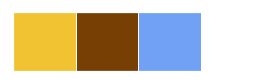

In [281]:
imp.reload(vp)

data = vp.create_chart_xy_components(d = time_data_daily, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

# Color and Category Selection
(color_palette, 
 category_list_names_ordered, 
 color_pairs_main) = vp.organize_categories_colors(d = data, 
                                                   category_column = breakdown_level_col, 
                                                   colors = None, 
                                                   specified_category_list = None)

sns.palplot(color_palette)
pd.DataFrame(color_pairs_main.items(), columns = ['category', 'color']).sort_values('category')

Colors Resources
- [Color Hex Faves](https://www.color-hex.com/)
- [Color Picker](https://www.w3schools.com/colors/colors_picker.asp)
- [Html color codes](https://htmlcolorcodes.com/)

In [277]:
params = {
    'figure.figsize' : (78,6), 
} 
plt.rcParams.update(params) 

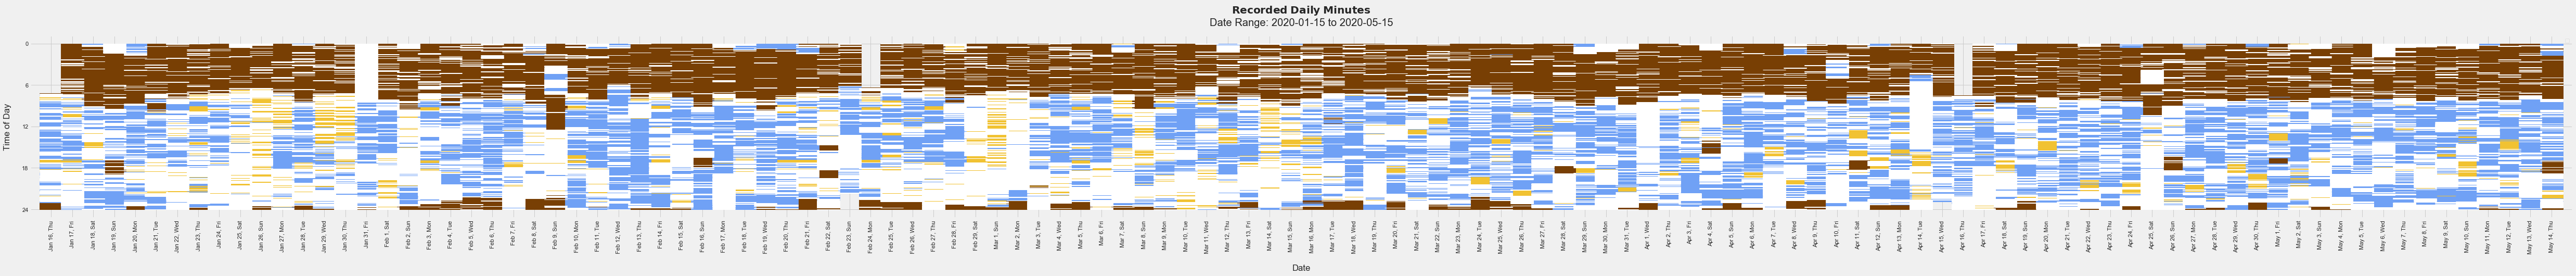

In [282]:
imp.reload(vp)

# Daily Stacked Chart
vp.daily_chart_24_hours(d = data, 
                        category_column = breakdown_level_col,
                        category_list_names_ordered = category_list_names_ordered,
                        color_palette = color_palette, 
                        add_reference_lines = False,
                        top_line = 9, 
                        bottom_line = 17,
                        legend_on = False,
                        turn_xaxis_on = True)

In [266]:
pivot_data = vp.pivot_data_with_missing_days(data = data,
                             specified_category_list = category_list_names_ordered.copy(), #['Design & Composition'] 
                             remove_no_entry_category = 1, 
                             values_column_name = 'duration_minutes',
                             values_hour_conversion = 60,
                             category_column = breakdown_level_col
                            )

#### Screen Time Usage

In [213]:
import datetime as dt

def screen_time_usage_summary(data):
    td = (data['date_time_min'].max() - data['date_time_min'].min())
    print(f'{data['date_time_min'].max()} -- {data['date_time_min'].min()}\n({td})\n')

    days, hours, minutes = td.days, td.seconds // 3600, td.seconds % 3600 / 60.0
    total_hours = round((td.days * 24) + (td.seconds // 3600) + (td.seconds % 3600 / (60.0 * 60.0)),2)
    tracked_hours = round(pivot_data.sum().sum(),2)

    data_onl = data[~(data[breakdown_level_col].isin(list(time_data_daily['Step Activity'].unique()) + list(time_data_daily['Sleep Stage'].unique())))]
    online_tracked_hours = round(data_onl['duration_minutes'].sum()/60,1)

    # Awake Hours
    data_inbed = data[(data[breakdown_level_col].isin(list(time_data_daily['Sleep Stage'].unique())))]
    inbed_tracked_hours = round(data_inbed['duration_minutes'].sum()/60,1)


    device_usage = {
        'Breakdown': ['Total', 'Tracked', 'Device', 'Device / Awake'],
        'Hours': [total_hours, 
                  tracked_hours, 
                  online_tracked_hours, 
                  online_tracked_hours],
        'Percentage': [100, 
                       round(tracked_hours * 100/ total_hours,2 ), 
                       round(online_tracked_hours * 100/ total_hours,2),
                       round(online_tracked_hours * 100/ (total_hours - inbed_tracked_hours),2) ]
    }

    du = pd.DataFrame.from_dict(device_usage)
    return data_onl, du

In [214]:
data['Date Abr'] = pd.to_datetime(data['Date Abr'])

In [215]:
pre_data = data[data['Date Abr'] <= '2020-03-16']
post_data = data[data['Date Abr'] >= '2020-03-16']

In [216]:
data_onl, dudf = screen_time_usage_summary(data = pre_data)
dudf

2020-01-16 -- 2020-05-15
(60 days 16:49:00)



,Breakdown,Hours,Percentage
0,Total,1456.82,100.00
1,Tracked,2123.82,145.78
2,Device,417.00,28.62
3,Device / Awake,417.00,67.96


In [217]:
data_onl, dudf = screen_time_usage_summary(data = post_data)
dudf

2020-01-16 -- 2020-05-15
(59 days 23:59:00)



,Breakdown,Hours,Percentage
0,Total,1439.98,100.00
1,Tracked,2123.82,147.49
2,Device,504.40,35.03
3,Device / Awake,504.40,78.31


In [218]:
data_onl, dudf = screen_time_usage_summary(data = data)
dudf

2020-01-16 -- 2020-05-15
(119 days 16:49:00)



,Breakdown,Hours,Percentage
0,Total,2872.82,100.00
1,Tracked,2123.82,73.93
2,Device,914.20,31.82
3,Device / Awake,914.20,73.35


In [219]:
data_onl_day = data_onl.groupby(['date_week'])['duration_minutes'].sum().reset_index()
data_onl_day['hours'] = round(data_onl_day['duration_minutes']/60,2)
data_onl_day[['date_week', 'hours']].head()

,date_week,hours
0,"2020-01-16, Thu",8.55
1,"2020-01-17, Fri",7.03
2,"2020-01-18, Sat",6.93
3,"2020-01-19, Sun",8.28
4,"2020-01-20, Mon",10.35


#### Visualize differences

In [255]:
def daily_with_rolling_average_charts(data, list_of_categories, rolling_period = 7):
    for i in list_of_categories: 
        data = pivot_data[[i]].reset_index()
        data['Date Abr'] = pd.to_datetime(data['Date Abr'])
        # Impute Missing values - Simple
        data[i].fillna(data[i].mean(), inplace=True)
        data[i] = np.where(data[i] < .10, data[i].mean(), data[i])

        # Categories and the matching colors
        cat_color_pairs_alt = {item: color_pairs_main.get(item) for item in [i]}
        colors_alt = list(cat_color_pairs_alt.values())


        # Provides more flexibility to play around with the second axis
        fig,ax1 = plt.subplots()

        ax1.bar(data['Date Abr'], data[i], color=colors_alt[0], alpha = .4)
        # ax1.set_xlabel("Days",fontsize=22)
#         ax1.set_ylabel("Hours",fontsize=22)
        ax1.set_ylim(0,13)



        ax2=ax1.twinx()
        # color_2nd = "#f16913"
        color_2nd = "black"

        ax2.plot(data['Date Abr'], data[i].rolling(window= rolling_period).mean(), color=color_2nd) #, linestyle = '--')
        # ax2.set_ylabel("Hours \n(7-day average)",color=color_2nd,fontsize=22)
        # ax2.tick_params(axis='y', colors=color_2nd)
        ax2.tick_params(labelright = False)
        ax2.legend([f'{rolling_period}-Day Rolling Average'])
        ax2.set_ylim(0,13)



        import matplotlib.dates as mdates
        ax2=plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
        ax2=plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))



        ## Reference Lines
        ax1.axvline(x='2020-03-16', linewidth=3, color='black', alpha = .5, linestyle = '--')
        # ax1.text(x='2020-03-17', y=8, s='Start of Shelter-in-Place', alpha=0.7, fontsize =19)

        plt.title(f'Daily {i.capitalize()} Hours\n Before and After Shelter-in-Place', fontweight='bold', fontsize = 30);


In [261]:
from scipy import stats

def distribution_charts(data, list_of_categories):

    for i in list_of_categories: 
        specified_category_entries = i
        data = pivot_data[[specified_category_entries]].reset_index()
        data['Date Abr'] = pd.to_datetime(data['Date Abr'])
        # Impute Missing values - Simple
        data[i].fillna(data[i].mean(), inplace=True)
        data[i] = np.where(data[i] < .10, data[i].mean(), data[i])


        fig = plt.figure(figsize=(10,5)) 

        # Colors
        cat_color_pairs_alt = {item: color_pairs_main.get(item) for item in [specified_category_entries]}
        colors_alt = list(cat_color_pairs_alt.values())

        # plot
        pre = data[data['Date Abr'] <= '2020-03-16'][specified_category_entries]
        post = data[data['Date Abr'] >= '2020-03-16'][specified_category_entries]

        ax1 = sns.distplot(pre, 
                           bins= 20, color = "#A9A9A9", label = 'Before Shelter', hist = False,
                          kde_kws={'linestyle':'--','clip': (0.0, 24)})
        ax2 = sns.distplot(post, 
                           bins= 10, color = colors_alt[0],  label = 'During Shelter', hist = False,
                          kde_kws={'clip': (0.0, 24)})
        plt.xlim(0,data[specified_category_entries].max())
        plt.title(f'Differences in {specified_category_entries.capitalize()} Time \n Before vs. During Shelter-in-Place', fontweight='bold')
        plt.xlabel(f'{specified_category_entries.capitalize()} Time (in hours)')
        ax2.legend([]);



        zval, pval = stats.ttest_ind(pre,post, equal_var = False)

        print(f' {specified_category_entries.capitalize()} differences have a pvalue {pval:0.3f}, pre mean: {pre.mean():0.2f} and post mean: {post.mean():0.2f}') 


In [271]:
params = {
    'figure.figsize' : (28,6), 
} 
plt.rcParams.update(params) 

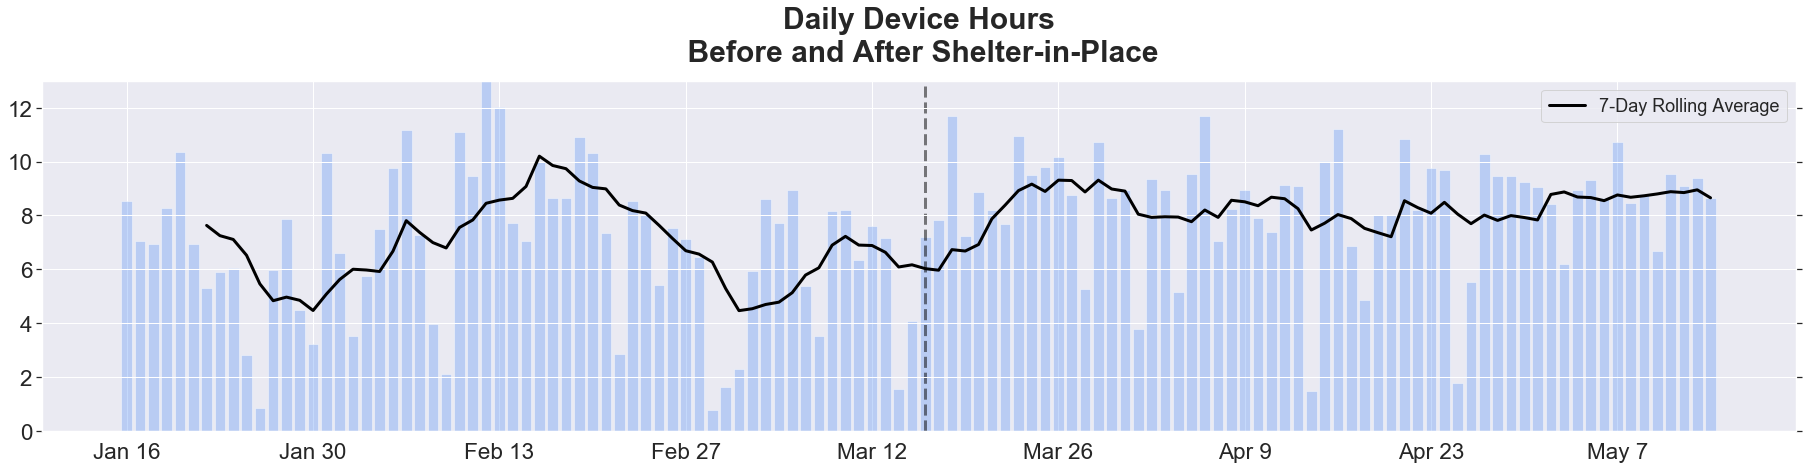

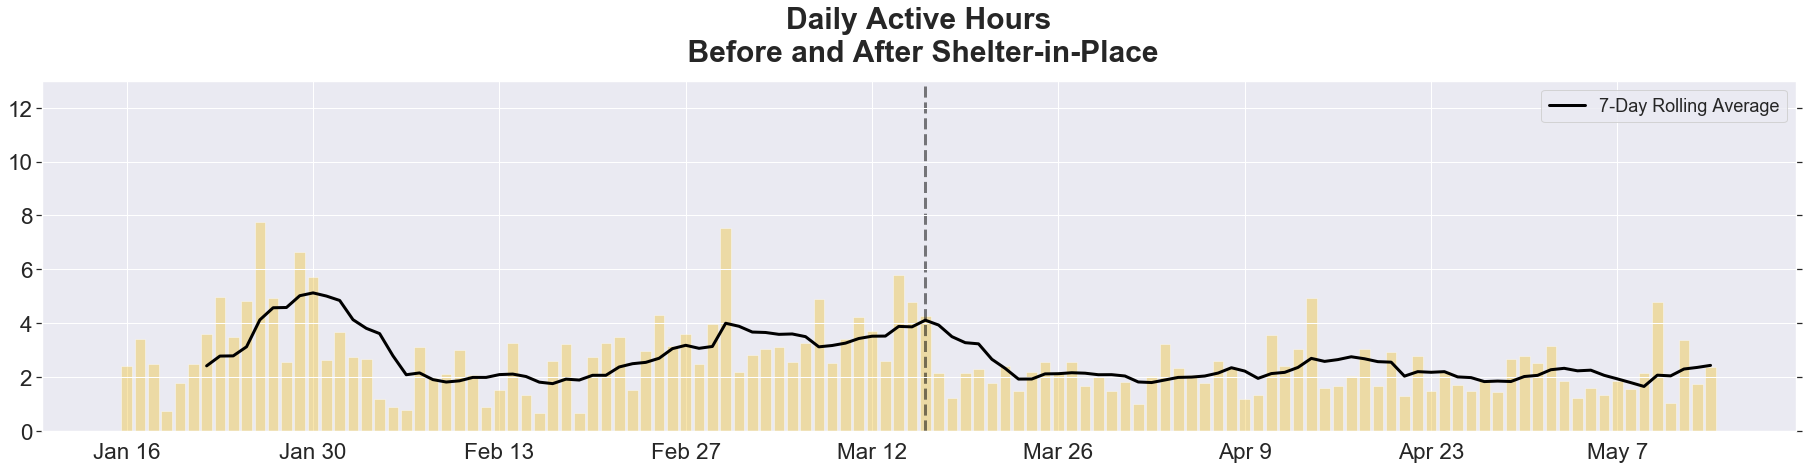

In [272]:
daily_with_rolling_average_charts(data = data, list_of_categories = ['device', 'active'], rolling_period = 7)

 Device differences have a pvalue 0.001, pre mean: 6.84 and post mean: 8.41
 Active differences have a pvalue 0.000, pre mean: 3.13 and post mean: 2.18


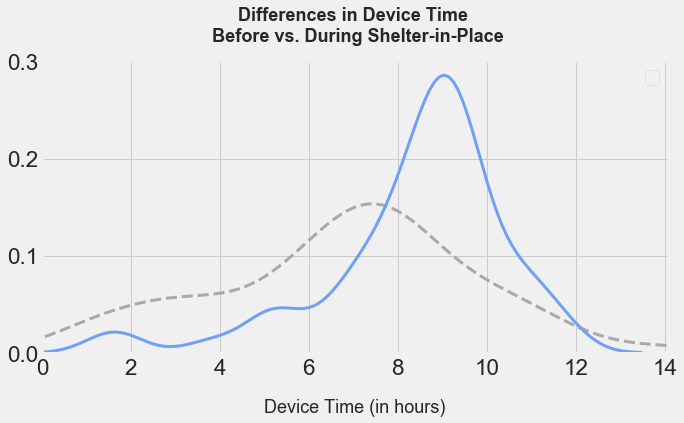

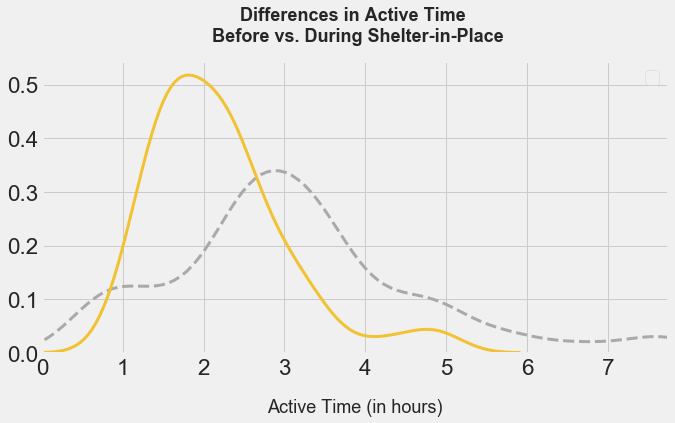

In [98]:
distribution_charts(data = data, list_of_categories = ['device', 'active'])

## Explore: Sleep

In [273]:
breakdown_level_col = 'Sleep Details'

,category,color
3,asleep,#783f04ff
4,awake,#7fffd4
2,no entry,#ffffff
1,other,#e8e8e8
0,restless,#ffccf2


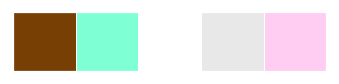

In [274]:
imp.reload(vp)

data = vp.create_chart_xy_components(d = time_data_daily, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

# Color and Category Selection
(color_palette, 
 category_list_names_ordered, 
 color_pairs_main) = vp.organize_categories_colors(d = data, 
                                                   category_column = breakdown_level_col, 
                                                   colors = None, 
                                                   specified_category_list = None)

sns.palplot(color_palette)
pd.DataFrame(color_pairs_main.items(), columns = ['category', 'color']).sort_values('category')

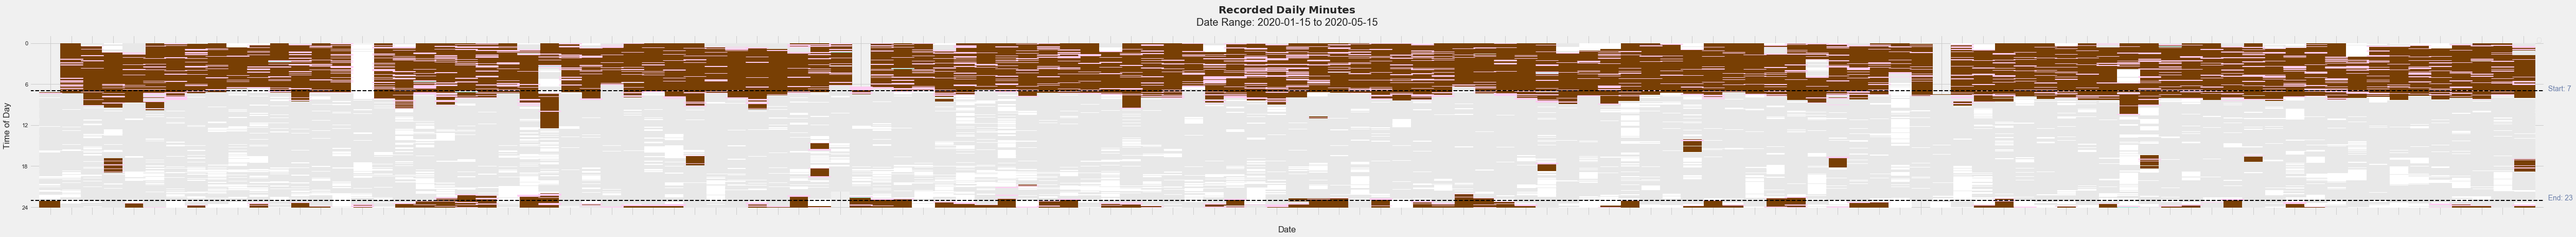

In [278]:
imp.reload(vp)
# Visualize
vp.daily_chart_24_hours(d = data, 
                        category_column = breakdown_level_col, #'Detail', #'Sleep Activity', 
                        category_list_names_ordered = category_list_names_ordered,
                        color_palette = color_palette, 
                        add_reference_lines = True,
                        top_line = 7, 
                        bottom_line = 23,
                        legend_on = False,
                        turn_xaxis_on = False
                       )

In [234]:
# Actual Time Ajustment - backwards
time_data_shifted = time_data_daily.copy()
time_data_shifted['Time'] = time_data_shifted['date_time_min'].dt.strftime('%H:M:S')

# Use 9pm as the cutoff 
for date_time_x in ['date_time', 'Date Start', 'date_time_min']:
    time_data_shifted[date_time_x] = np.where((time_data_shifted['Time'] >= '21:00:00') & (time_data_shifted['Time'] < '24:00:00'), 
                                     time_data_shifted[date_time_x] - pd.DateOffset(days=1), 
                                     time_data_shifted[date_time_x])


In [235]:
data = vp.create_chart_xy_components(d = time_data_shifted, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

In [236]:
pivot_data = vp.pivot_data_with_missing_days(data = data[data[breakdown_level_col].isin(['asleep','restless','awake'])],
                             specified_category_list = category_list_names_ordered.copy(), #['asleep', 'no entry']
                             remove_no_entry_category = 1, 
                             values_column_name = 'duration_minutes',
                             values_hour_conversion = 60,
                             category_column = breakdown_level_col
                            )

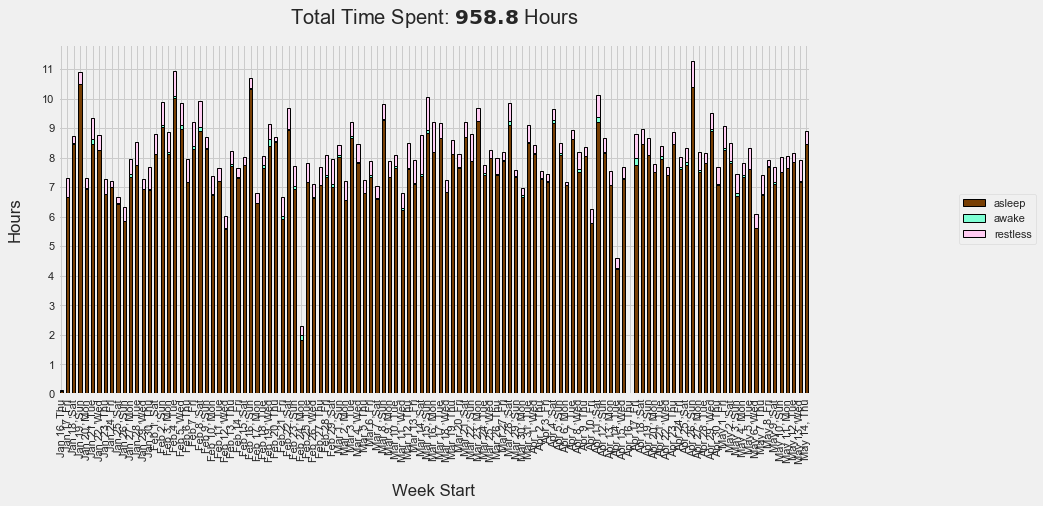

In [237]:
vp.stacked_bar_chart_categories(pivot_data = pivot_data, 
                                color_pairs = color_pairs_main,
                                legend_on = 1,
                                ymax = 12, ystep = 1)

In [258]:
params = {
    'figure.figsize' : (30,8), 
} 
plt.rcParams.update(params) 

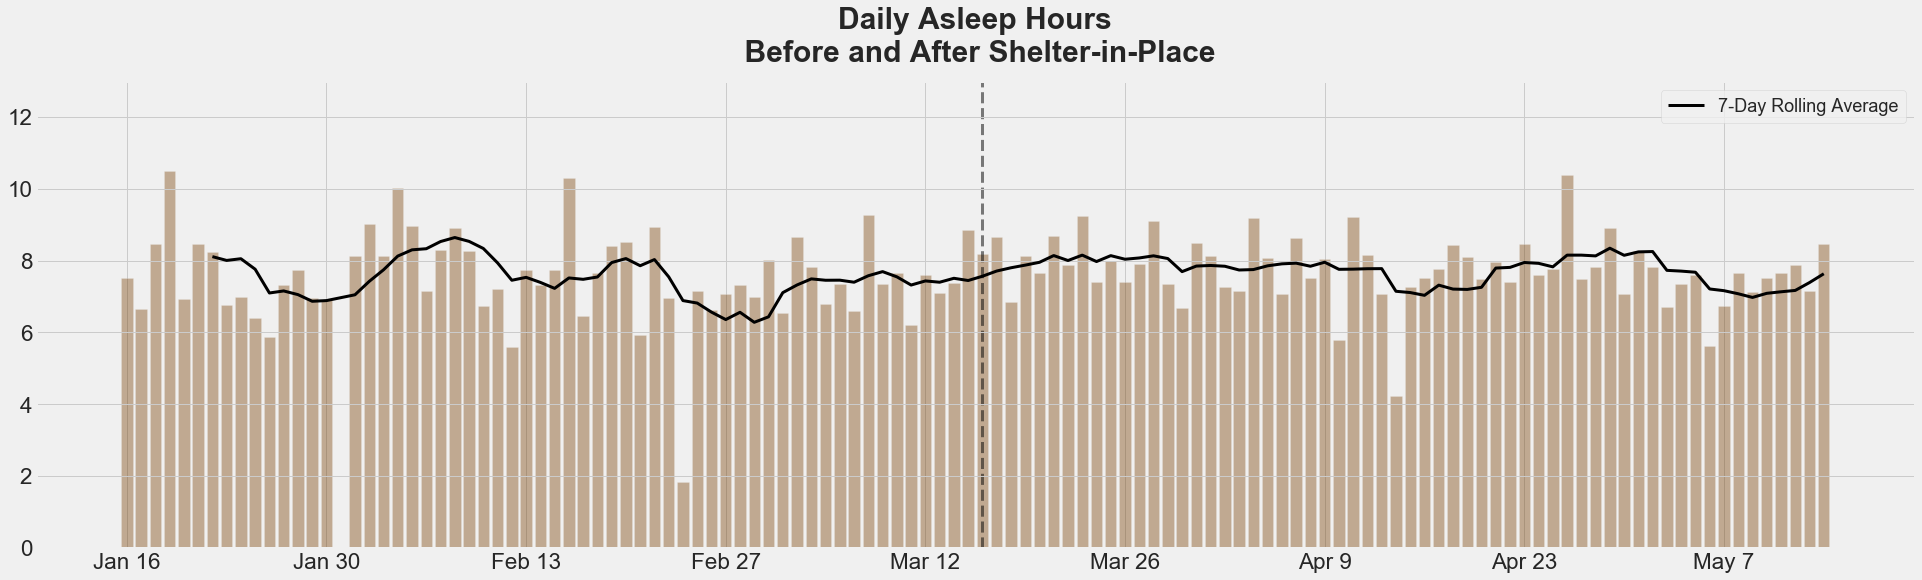

In [263]:
daily_with_rolling_average_charts(data = data, list_of_categories = ['asleep'], rolling_period = 7)

 Asleep differences have a pvalue 0.347, pre mean: 7.54 and post mean: 7.74
 Restless differences have a pvalue 0.014, pre mean: 0.56 and post mean: 0.47


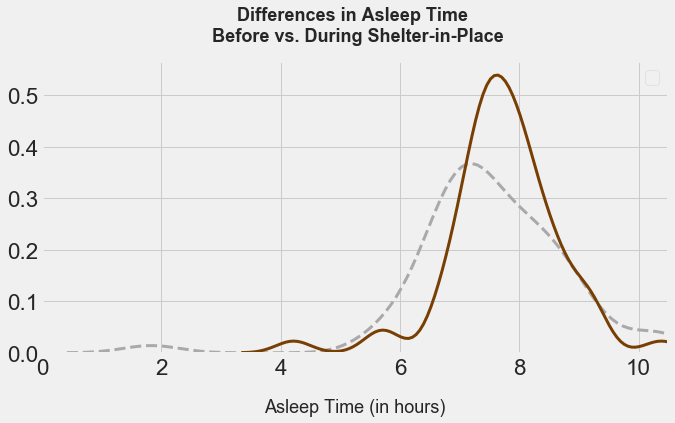

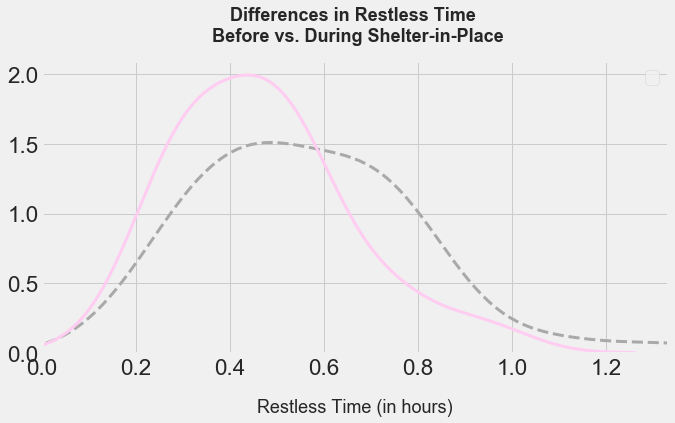

In [262]:
distribution_charts(data = data, list_of_categories = ['asleep', 'restless'])